In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
import lightgbm as lgb
import matplotlib

In [2]:
df_csv = pd.read_csv('fraud_data.csv')

In [3]:
shape = df_csv.shape
print('shape = {}'.format(shape))

shape = (500, 7)


In [4]:
df_csv.isnull().sum()

TransactionID        0
Amount              25
Time                 0
Location            25
MerchantCategory     0
CardHolderAge       24
IsFraud              0
dtype: int64

In [12]:
df_csv.isnull().sum() /len(df_csv) *100

TransactionID       0.0
Amount              5.0
Time                0.0
Location            5.0
MerchantCategory    0.0
CardHolderAge       4.8
IsFraud             0.0
dtype: float64

In [13]:
df_csv.dtypes

TransactionID         int64
Amount              float64
Time                  int64
Location             object
MerchantCategory     object
CardHolderAge       float64
IsFraud               int64
dtype: object

In [14]:
df_csv.MerchantCategory.duplicated().sum

<bound method Series.sum of 0      False
1      False
2       True
3      False
4       True
       ...  
495     True
496     True
497     True
498     True
499     True
Name: MerchantCategory, Length: 500, dtype: bool>

In [15]:
df_csv['IsFraud'].value_counts(normalize=True) * 100

IsFraud
0    94.6
1     5.4
Name: proportion, dtype: float64

In [16]:
fraud_ratio = df_csv['IsFraud'].value_counts()[1] / len(df_csv)
print(f"Fraud ratio: {fraud_ratio:.2%}")

Fraud ratio: 5.40%


In [17]:
df = df_csv.drop('TransactionID', axis =1)
print(df)

     Amount   Time     Location MerchantCategory  CardHolderAge  IsFraud
0    375.17  47605      Houston           Travel           18.0        0
1    950.76  38088  Los Angeles      Electronics           28.0        0
2    732.26  78752        Miami           Travel           20.0        0
3    599.06  55284     New York        Groceries           69.0        0
4    156.86  57043     New York        Groceries           79.0        0
..      ...    ...          ...              ...            ...      ...
495  354.00  48770      Houston           Travel           21.0        0
496  584.07  78623        Miami        Groceries           64.0        1
497   78.66  75629        Miami         Clothing           78.0        0
498  974.42  52603  Los Angeles      Electronics           21.0        1
499  986.22  81974      Chicago      Electronics           37.0        0

[500 rows x 6 columns]


In [18]:
pd.to_datetime(df['Time'], unit='s')

0     1970-01-01 13:13:25
1     1970-01-01 10:34:48
2     1970-01-01 21:52:32
3     1970-01-01 15:21:24
4     1970-01-01 15:50:43
              ...        
495   1970-01-01 13:32:50
496   1970-01-01 21:50:23
497   1970-01-01 21:00:29
498   1970-01-01 14:36:43
499   1970-01-01 22:46:14
Name: Time, Length: 500, dtype: datetime64[ns]

In [19]:
# le = LabelEncoder()
# le.fit_transform(df_csv['Location'])
le = LabelEncoder()
df['Location'] = le.fit_transform(df['Location'])

In [20]:
le = LabelEncoder()
df['MerchantCategory'] = le.fit_transform(df['MerchantCategory'])

In [21]:
for col in df_csv.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

In [22]:
fraud_rate = df.groupby('MerchantCategory')['IsFraud'].mean()
fraud_rate = df['MerchantCategory'].map(fraud_rate)

In [23]:
scaler = StandardScaler()
scaler.fit_transform(df[['Amount', 'CardHolderAge']])

array([[-2.54893608e-01, -1.58212727e+00],
       [ 2.96782308e-01, -1.04615646e+00],
       [ 8.73603449e-02, -1.47493311e+00],
       [-4.03055840e-02,  1.15132384e+00],
       [-4.64133465e-01,  1.68729465e+00],
       [-4.64152634e-01, -4.02991495e-01],
       [-5.57898914e-01, -2.42200253e-01],
       [ 2.15840959e-01, -1.42133603e+00],
       [-3.79573743e-02, -6.70976898e-01],
       [ 6.44533201e-02,  1.31211508e+00],
       [-5.93812145e-01, -1.31414187e+00],
       [ 3.15165435e-01,  2.40173473e-01],
       [ 1.83541095e-01, -4.56588575e-01],
       [-4.10201319e-01,             nan],
       [-4.39424549e-01, -8.31768140e-01],
       [-4.37910193e-01, -4.56588575e-01],
       [-3.22205757e-01,  1.58010049e+00],
       [-1.11068163e-01,  3.47367634e-01],
       [ 6.72867172e+00,  1.15132384e+00],
       [-3.34665644e-01,  6.15353037e-01],
       [-2.76731745e-02, -9.92559381e-01],
       [-4.79957522e-01,  8.83338440e-01],
       [-3.33793452e-01,  9.90532601e-01],
       [-2.

In [24]:
print(df['Amount'].mean())
print(df['Amount'].std())
print(df['CardHolderAge'].mean())
print(df['CardHolderAge'].std())

641.1127530842106
1044.4480647858059
47.51890756302521
18.67736202673582


In [25]:
scaler = MinMaxScaler()
scaler.fit_transform(df[['Amount', 'CardHolderAge']])

array([[3.81094718e-02, 1.13043478e-01],
       [9.75373684e-02, 2.00000000e-01],
       [7.49779157e-02, 1.30434783e-01],
       [6.12254255e-02, 5.56521739e-01],
       [1.55696360e-02, 6.43478261e-01],
       [1.55675711e-02, 3.04347826e-01],
       [5.46898952e-03, 3.30434783e-01],
       [8.88181657e-02, 1.39130435e-01],
       [6.14783805e-02, 2.60869565e-01],
       [7.25103142e-02, 5.82608696e-01],
       [1.60032731e-03, 1.56521739e-01],
       [9.95176444e-02, 4.08695652e-01],
       [8.53387444e-02, 2.95652174e-01],
       [2.13793404e-02,            nan],
       [1.82313417e-02, 2.34782609e-01],
       [1.83944718e-02, 2.95652174e-01],
       [3.08584404e-02, 6.26086957e-01],
       [5.36027051e-02, 4.26086957e-01],
       [7.90396432e-01, 5.56521739e-01],
       [2.95162304e-02, 4.69565217e-01],
       [6.25862199e-02, 2.08695652e-01],
       [1.38650293e-02, 5.13043478e-01],
       [2.96101851e-02, 5.30434783e-01],
       [3.72659445e-02,            nan],
       [4.651790

In [26]:
df['IsFraud'].value_counts(normalize=True) * 100

IsFraud
0    94.6
1     5.4
Name: proportion, dtype: float64

In [27]:
X = df.drop('IsFraud', axis=1)
y = df['IsFraud']

In [28]:
X = X.dropna()
y = y.loc[X.index]

In [29]:
from sklearn.impute import SimpleImputer
import pandas as pd

# Numeric imputation
num_imputer = SimpleImputer(strategy="median")

X = pd.DataFrame(num_imputer.fit_transform(X), columns=X.columns)

In [30]:
print(X.isnull().sum())

Amount              0
Time                0
Location            0
MerchantCategory    0
CardHolderAge       0
dtype: int64


In [31]:
cat_imputer = SimpleImputer(strategy="most_frequent")

In [32]:
from sklearn.impute import SimpleImputer
num_cols = ['Amount', 'CardHolderAge']  # Add any other numerics
cat_cols = ['Location', 'MerchantCategory']  # Add any other categoricals

# Impute numerics (use 'median' if data is skewed)
# num_imputer = SimpleImputer(strategy='mean')  
num_imputer = SimpleImputer(strategy='median') 
cat_imputer = SimpleImputer(strategy='most_frequent')
df[num_cols] = num_imputer.fit_transform(df[num_cols])
df[num_cols] = num_imputer.fit_transform(df[num_cols])
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

X = df.drop('IsFraud', axis=1)
y = df['IsFraud']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [37]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [35]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [38]:
from sklearn.preprocessing import LabelEncoder
for col in ['Location', 'MerchantCategory']:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))

In [39]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting': 'gbdt',
    'is_unbalance': True,   # handles imbalance automatically
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'seed': 42
}

model = lgb.train(params, train_data, valid_sets=[test_data], 
                  num_boost_round=500, 
                  callbacks=[lgb.early_stopping(50)])  # NEW way

[LightGBM] [Info] Number of positive: 378, number of negative: 378
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 770
[LightGBM] [Info] Number of data points in the train set: 756, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [48]:
y_prob = model.predict(X_test)  
y_pred = (y_prob > 0.3).astype(int)  

In [49]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_prob))

Confusion Matrix:
 [[50 45]
 [ 2  3]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.53      0.68        95
           1       0.06      0.60      0.11         5

    accuracy                           0.53       100
   macro avg       0.51      0.56      0.40       100
weighted avg       0.92      0.53      0.65       100


ROC AUC Score: 0.5936842105263157


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

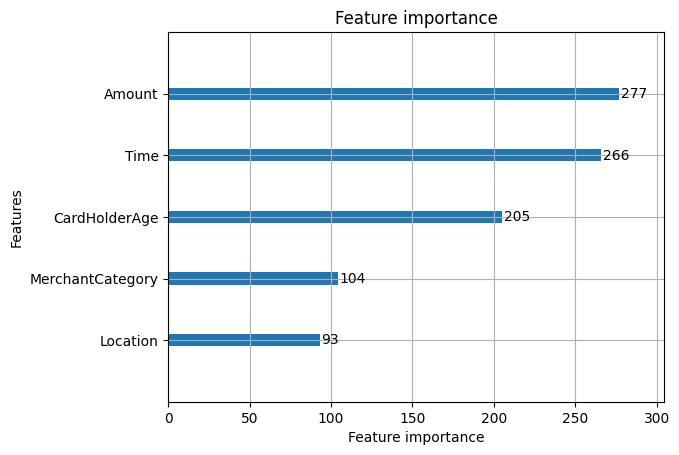

In [50]:
lgb.plot_importance(model, max_num_features=10)

In [42]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

param_grid = {
    'num_leaves': [31, 63, 127],
    'max_depth': [-1, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 500, 1000],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}

lgbm = lgb.LGBMClassifier(objective='binary', metric='auc', random_state=42)

grid = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Best AUC:", grid.best_score_)

Fitting 3 folds for each of 729 candidates, totalling 2187 fits


KeyboardInterrupt: 

KeyboardInterrupt: 